In [1]:
from utils.physics.sound_model import ISAS_grid as isg

from utils.physics.sound_model.ISAS_grid import extract_velocity_profile
import numpy as np
from cartopy.feature import LAND, COASTLINE
PATH = "/media/rsafran/CORSAIR/ISAS/86442/field/2018"
month = 1
lat_bounds= [-70, 20]
lon_bounds = [15, 150]


ds = isg.load_ISAS_TS(PATH, month,lat_bounds,lon_bounds, fast=False)


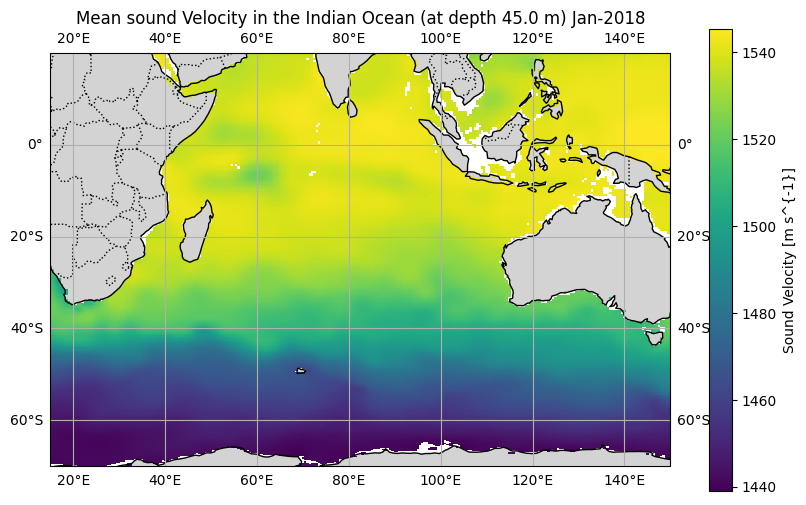

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
# Define latitude and longitude bounds for the Indian Ocean
lat_min, lat_max = lat_bounds  # Latitude bounds (approximately from 30°S to 30°N)
lon_min, lon_max = lon_bounds  # Longitude bounds (approximately from 30°E to 120°E)

# Create a map projection (PlateCarree is a simple projection for global data)
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add coastlines and land features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Plot temperature at a specific depth (e.g., depth index 10)
temp_at_depth = ds['SOUND_VELOCITY'].isel(depth=10).squeeze()
temp_at_depth.plot(transform=ccrs.PlateCarree(), ax=ax)

# Add labels
ax.set_title(f'Mean sound Velocity in the Indian Ocean (at depth {ds["depth"][10].values} m) Jan-2018')
ax.gridlines(draw_labels=True)

plt.show()

In [3]:
# Define start and end points
lat1, lon1 = -24.2053, 63.0102  # Example: Station MADE
lat2, lon2 = -31.5758, 83.2423  # Example: Station NEAMS
depth = 1500  # Depth in meters

# Compute travel time
travel_time, total_distance = isg.compute_travel_time(lat1, lon1, lat2, lon2, depth, ds, resolution=3)

# Total distance: 2148.56 km
# Segments: 716
# Velocity: mean=1487.07 m/s, min=1486.78, max=1487.55
# Travel time: 1444.83 s (0.40 hr)
# Travel time between A and B at depth 1500 m: 1444.83 seconds
# Total distance: 2148.56 km

# Print results
print(f"Travel time between A and B at depth {depth} m: {travel_time:.2f} seconds")
print(f"Total distance: {total_distance / 1000:.2f} km")

Total distance: 2148.56 km
Segments: 716
Velocity: mean=1487.64 m/s, min=1487.35, max=1488.11
Travel time: 1444.28 s (0.40 hr)
Travel time between A and B at depth 1500 m: 1444.28 seconds
Total distance: 2148.56 km


In [4]:
isg.compute_travel_time(lat1, lon1, lat2, lon2, depth, ds, resolution=10, verbose=True)

Total distance: 2148.56 km
Segments: 214
Velocity: mean=1487.64 m/s, min=1487.35, max=1488.11
Travel time: 1444.28 s (0.40 hr)


(1444.2761049494325, 2148557.9426972526)

In [5]:
tt = []
for i in range(1,100):
    tt0, td = isg.compute_travel_time(lat1, lon1, lat2, lon2, depth, ds, resolution=i*0.5, verbose=False)
    tt.append(tt0)

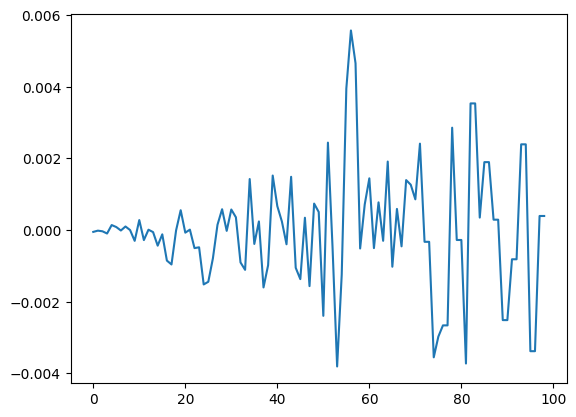

In [6]:
# plt.plot(np.array(tt)[1:]-np.array(tt)[-1:])
plt.plot(np.mean(tt)-np.array(tt))
# plt.plot(tt)

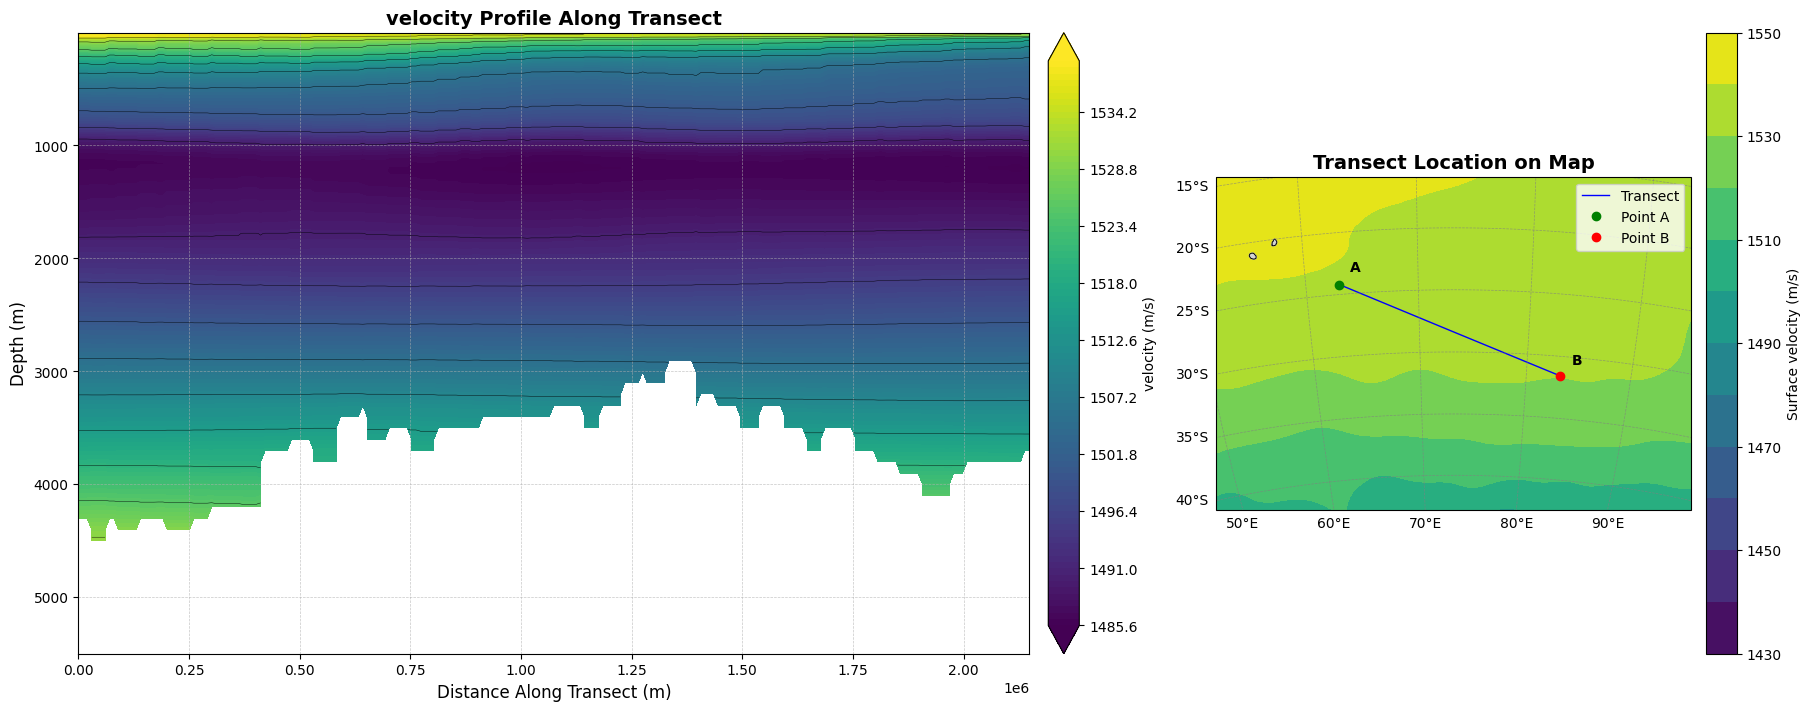

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from cartopy.feature import LAND, COASTLINE
import matplotlib.gridspec as gridspec
# Define points A and B
lat1, lon1 = -24.2053, 63.0102  # Example: Station MADE
lat2, lon2 = -31.5758, 83.2423 # Point B
resolution = 10000         # 10 km resolution

# Generate transect
coordinates, distances, total_distance = isg._generate_coordinates_with_fixed_resolution(
    lat1, lon1, lat2, lon2, resolution
)

# Extract velocity profile along transect
velocity_profile, depths = isg.extract_velocity_profile(ds, coordinates)

# Setup figure and axes

fig = plt.figure(figsize=(18, 7), constrained_layout=True)
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1], figure=fig)

# Plot 1: velocity profile
ax1 = fig.add_subplot(gs[0])

# Plot 2: map
ax2 = fig.add_subplot(gs[1], projection=ccrs.Orthographic(central_longitude=(lon1+lon2)*0.5, central_latitude=(lat1+lat2)*0.5))

# === Plot 1: velocity Profile ===
c1 = ax1.contourf(distances, depths, velocity_profile, levels=100, cmap='viridis', extend='both')
ax1.contour(distances, depths, velocity_profile, colors='black', linewidths=0.3, levels=10)

cb1 = plt.colorbar(c1, ax=ax1, label='velocity (m/s)', pad=0.02)
ax1.invert_yaxis()
ax1.set_xlabel('Distance Along Transect (m)', fontsize=12)
ax1.set_ylabel('Depth (m)', fontsize=12)
ax1.set_title('velocity Profile Along Transect', fontsize=14, weight='bold')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# === Plot 2: Map with Transect ===
# Surface velocity map
temp_at_surface = ds['SOUND_VELOCITY'].sel(depth=1, method='nearest').squeeze()
c2 = ax2.contourf(
    ds['longitude'], ds['latitude'], temp_at_surface,
    levels=10, transform=ccrs.PlateCarree()
)
cb2 = plt.colorbar(c2, ax=ax2, orientation='vertical', label='Surface velocity (m/s)', pad=0.03)

# Map features
ax2.add_feature(LAND, edgecolor='black', color='lightgray', zorder=1)
ax2.add_feature(COASTLINE, linewidth=0.7)

# Transect line and endpoints
transect_lats, transect_lons = zip(*coordinates)
ax2.plot(transect_lons, transect_lats, color='blue', linewidth=1,
         transform=ccrs.PlateCarree(), label='Transect')

ax2.plot(lon1, lat1, 'go', transform=ccrs.PlateCarree(), label='Point A')
ax2.text(lon1 + 1, lat1 + 1, 'A', transform=ccrs.PlateCarree(), fontsize=10, weight='bold')

ax2.plot(lon2, lat2, 'ro', transform=ccrs.PlateCarree(), label='Point B')
ax2.text(lon2 + 1, lat2 + 1, 'B', transform=ccrs.PlateCarree(), fontsize=10, weight='bold')

# Set map extent with margin
margin = 10
ax2.set_extent([
    min(lon1, lon2) - margin, max(lon1, lon2) + margin,
    min(lat1, lat2) - margin, max(lat1, lat2) + margin
], crs=ccrs.PlateCarree())

# Gridlines
gl = ax2.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--', alpha=0.7)
gl.right_labels = False
gl.top_labels = False

# Title and legend
ax2.set_title('Transect Location on Map', fontsize=14, weight='bold')
ax2.legend(loc='best', fontsize=10)

plt.show()